# Subtask 1
## K-means Clustering

Requirements:

- Python 3.13.1
- numpy
- pandas
- scikit-learn
- matplotlib

In [12]:
import logging
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt


## Preprocessing
Load the data and preprocess it. Drop features we dont need. Since we are working with mixed-type data, we need to encode features that are not continuous numeric. Also, missing values need to be imputated.

In [2]:
df = pd.read_csv("../dataset/tracks.csv")
df.head()

,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",False
3,TR480968,ART04205421,Rosa Chemical,CEO by Rosa Chemical (Ft. Taxi B),CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,39890.0,...,single,1.0,2.0,169000.0,True,47.0,https://i.scdn.co/image/ab67616d0000b27367c03d...,ALB730959,Designer sui vestiti penso di essere un outlet...,False
4,TR585039,ART04205421,Rosa Chemical,LONDRA by Rosa Chemical (Ft. Rkomi),LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,35432.0,...,album,1.0,8.0,194779.0,True,41.0,https://i.scdn.co/image/ab67616d0000b273fcdb60...,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",False


### Drop Irrelevant Features
Many columns such as names or unique identifiers are not relevant for clustering. We drop them.

In [3]:
cols_to_drop = ["id",
    "id_artist",
    "name_artist",
    "full_title",
    "title",
    "album_name",
    "album_release_date",
    "id_album",
    "album_image",
    "lyrics",
    "swear_IT_words",
    "swear_EN_words",
    "month",
    "day",
    "disc_number",
    "track_number"
]

df = df.drop(columns=cols_to_drop)

In [4]:
# Relevant preprocessing functions

def clean(df: pd.DataFrame) -> pd.DataFrame:
    # Replace empty cells (or ?) with NA
    df = df.replace(r"^\?|\s+$", pd.NA, regex=True)

    # Columns with whitespace (or ?) values are infered as string type but could be numeric
    for col in df.select_dtypes(exclude=[np.number, np.bool_]).columns:
        # Exclude booleans
        if df[col].nunique() > 2:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                logging.debug("Could not convert column %s to numeric dtype", col)

    # Integer columns with missing values automatically get converted to float columns
    # We want to convert back to integer to allow for better column classification (num/cat)
    for col in df.select_dtypes(include=np.floating):
        if np.all(df[col].fillna(0) % 1 == 0):
            df[col] = df[col].astype("Int64")

    # Turn object columns into string columns (causes issues with stepmix)
    for col in df.select_dtypes(include=object).columns:
        df[col] = df[col].astype(str)

    return df


def classify_cols(
    df: pd.DataFrame,
    bool_cols: bool = False,
) -> Tuple:
    # All floating point columns are considered numeric
    num_cols: List[str] = list(df.select_dtypes(include=np.inexact).columns)
    cat_cols: List[str] = []
    bool_cols_: List[str] = list(df.select_dtypes(include=np.bool_).columns) if bool_cols else []

    remaining_cols = df.columns.difference(num_cols + bool_cols_)

    if bool_cols:
        for col in remaining_cols:
            if df[col].nunique() <= 2:
                bool_cols_.append(col)
                remaining_cols = remaining_cols.drop(col)

    # Integer columns with more than 50 unique values are considered numeric
    for col in df[remaining_cols].select_dtypes(include=np.integer).columns:
        if df[col].nunique() >= 50:
            num_cols.append(col)
            remaining_cols = remaining_cols.drop(col)

    # All other columns are considered categorical
    cat_cols = list(remaining_cols)

    logging.info("Num cols: %s", num_cols)
    logging.info("Cat cols: %s", cat_cols)
    logging.info("Bool cols: %s", bool_cols_)
    if bool_cols:
        return num_cols, cat_cols, bool_cols_
    return num_cols, cat_cols


def scale_cols(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if num_cols:
        df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    if bool_cols:
        df[bool_cols] = df[bool_cols].apply(LabelEncoder().fit_transform)
    return df


def imputate_na(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    if num_cols:
        # imputate numeric features
        for col in num_cols:
            df[col] = df[col].fillna(round(df[col].median()))
    if cat_cols is None:
        cat_cols = []
    if bool_cols is None:
        bool_cols = []
    # add "missing" category for categorical features
    for col in cat_cols + bool_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].fillna("<NA>")
    return df


### Cleaning, Imputating, Scaling and Labelling
Now execute the functions from above to return a dataframe we can use for computation.

In [5]:
df = clean(df)
num_cols, cat_cols, bool_cols = classify_cols(df, bool_cols=True)
df = imputate_na(df, num_cols, cat_cols, bool_cols)
df = scale_cols(df, num_cols, cat_cols, bool_cols)

df.head()

,featured_artists,primary_artist,language,album,stats_pageviews,swear_IT,swear_EN,year,n_sentences,n_tokens,...,zcr,flatness,spectral_complexity,pitch,loudness,album_type,duration_ms,explicit,popularity,modified_popularity
0,485,82,24,240,4.382687,5,34,104,1.730216,1.986653,...,2.245231,-0.371348,-0.201151,0.144966,-0.737947,0,0.048662,1,82,0
1,1579,82,9,240,3.566031,43,4,103,-0.137659,0.854572,...,2.940790,-1.709861,0.202091,-0.954668,-0.321424,0,0.048662,1,82,0
2,1004,82,9,240,0.821598,8,4,104,1.161733,1.252719,...,0.918816,-0.700716,-0.051288,0.599459,0.606187,0,-0.112995,1,72,0
3,1555,82,17,555,0.345227,42,21,102,-0.909173,-0.550936,...,-1.043848,0.142831,-1.557827,1.912401,-0.431909,3,-0.392077,1,83,0
4,1382,82,9,240,0.229954,1,0,103,-0.462507,-0.325479,...,0.352663,-0.033747,1.103381,-1.794887,0.128634,0,-0.098952,1,75,0


### Encoding
Now we use one-hot encoding to encode the categorical features. Boolean features only need encoding if they contain NaN or NA values (=missing values), otherwise they are left as is. To reduce the number of features, we only encode features that have more unique values than a threshhold. This will get rid of features with too many unique values, such as song lyrics. These features would add up to N new features to the dataset, which is not a good idea.

In [6]:
def one_hot_encode_feature(df: pd.DataFrame, feature_to_encode: str, weight: float = 1) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature_to_encode], dtype="int32", prefix=feature_to_encode)
    dummies *= weight
    result_df = pd.concat([df, dummies], axis=1)
    return result_df.drop(columns=feature_to_encode)


encoded_df = df.copy(deep=True)

for col in cat_cols + [col for col in bool_cols if encoded_df[col].nunique() > 2]:
    # Dont encode columns with too many unique values
    if encoded_df[col].nunique() > 50:
        logging.warning("Column %s has too many unique values, dropping", col)
        encoded_df = encoded_df.drop(columns=col)
    else:
        encoded_df = one_hot_encode_feature(encoded_df, col)

encoded_df.head()

,stats_pageviews,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,bpm,centroid,rolloff,...,swear_IT_34,swear_IT_35,swear_IT_36,swear_IT_37,swear_IT_38,swear_IT_39,swear_IT_40,swear_IT_41,swear_IT_42,swear_IT_43
0,4.382687,1.730216,1.986653,0.046638,0.261922,0.786870,0.009550,0.793368,1.642220,2.259997,...,0,0,0,0,0,0,0,0,0,0
1,3.566031,-0.137659,0.854572,0.598627,0.510317,1.792820,0.310083,0.570975,2.354421,3.112774,...,0,0,0,0,0,0,0,0,0,1
2,0.821598,1.161733,1.252719,-0.009536,0.047712,0.535180,0.029394,0.732070,1.558628,0.743616,...,0,0,0,0,0,0,0,0,0,0
3,0.345227,-0.909173,-0.550936,0.292905,-0.067872,0.227492,-0.089032,1.798812,-1.066151,-0.813071,...,0,0,0,0,0,0,0,0,1,0
4,0.229954,-0.462507,-0.325479,0.047721,-0.295177,-0.358439,0.028674,-0.307387,0.181037,0.135803,...,0,0,0,0,0,0,0,0,0,0


## Clustering
We can now cluster the songs using K-means clustering. We use k-means++ to get a better initialization. The algorithm is run 100 times and inertia is used to determine the best result. Inertia is the sum of squared distances between each data point and its assigned centroid. Lower inertia means better clustering results.

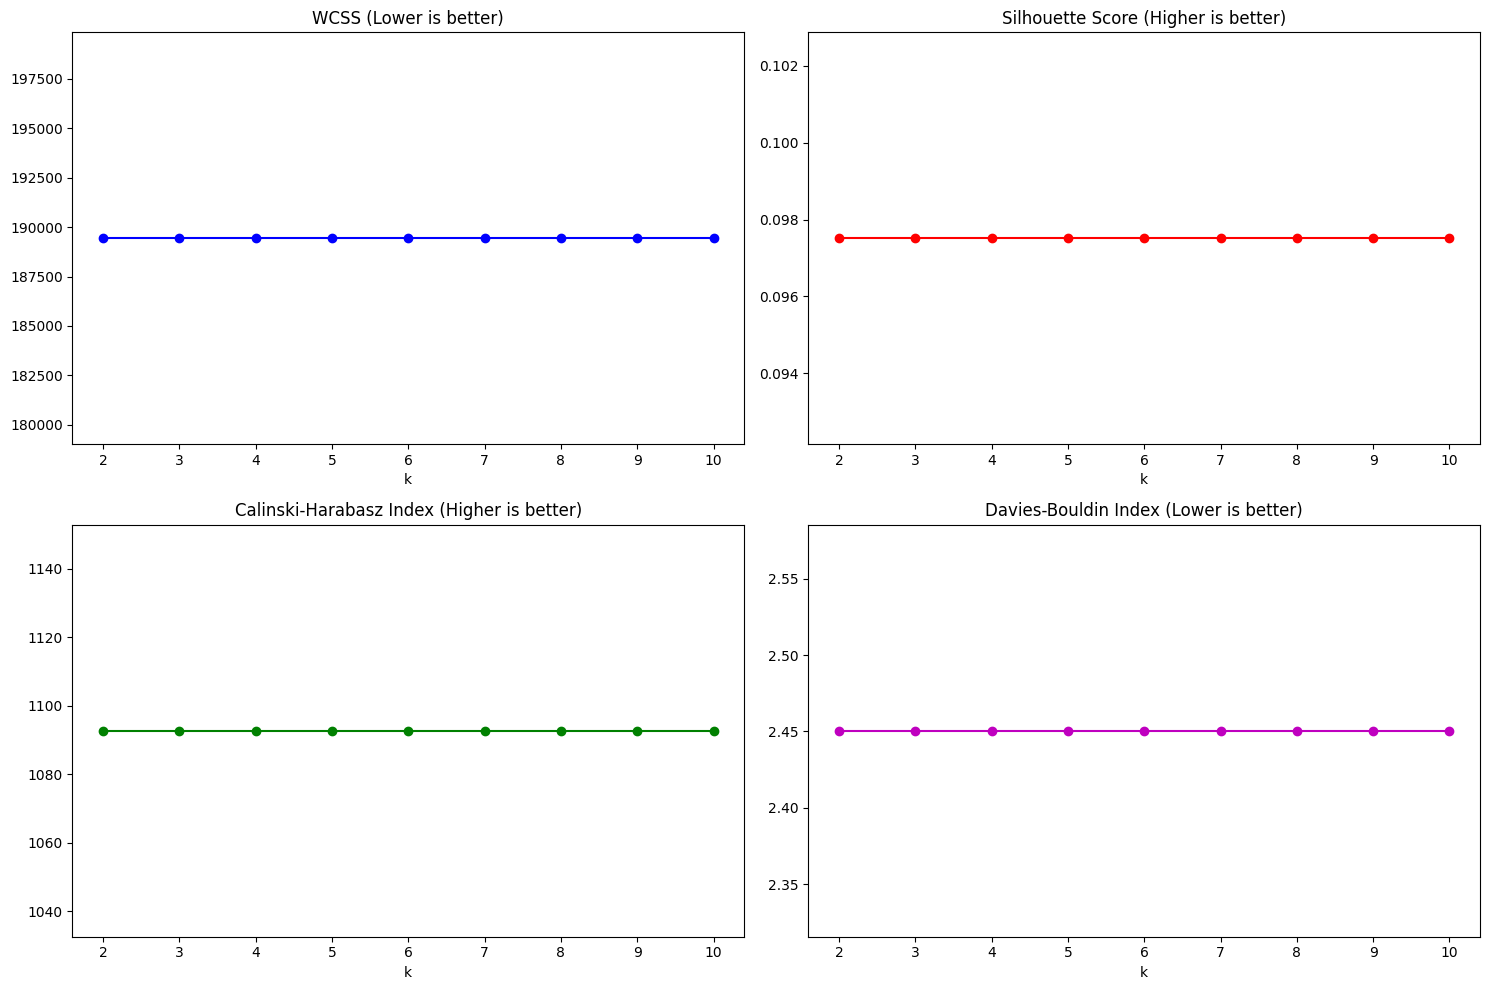

In [ ]:
metrics = {
    'wcss': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

X = encoded_df.values

k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=3, init="k-means++", n_init=100)
    labels = kmeans.fit_predict(encoded_df)

    metrics['wcss'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(k_range, metrics['wcss'], 'bo-')
axes[0,0].set_title('WCSS (Lower is better)')
axes[0,0].set_xlabel('k')

axes[0,1].plot(k_range, metrics['silhouette'], 'ro-')
axes[0,1].set_title('Silhouette Score (Higher is better)')
axes[0,1].set_xlabel('k')

axes[1,0].plot(k_range, metrics['calinski_harabasz'], 'go-')
axes[1,0].set_title('Calinski-Harabasz Index (Higher is better)')
axes[1,0].set_xlabel('k')

axes[1,1].plot(k_range, metrics['davies_bouldin'], 'mo-')
axes[1,1].set_title('Davies-Bouldin Index (Lower is better)')
axes[1,1].set_xlabel('k')

plt.tight_layout()
plt.show()